####Сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок
value – значения метрики
experimentVariant – вариант теста (Control – контроль, Treatment – тест)

In [30]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(12,6)}, style = 'whitegrid')

In [3]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-varenichenko-22/My_practice/Modul_6_Statistics/hw_bootstrap.csv', sep=";", decimal = ",", 
                 index_col=[0])

In [4]:
df.head(5)

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control


Для проведения теста поделим вариант эксперимента на 2 группы

In [5]:
sample_1 = df.query('experimentVariant == "Control"').value
sample_2 = df.query('experimentVariant == "Treatment"').value

Посмотрим на их распределения и наличие выбросов

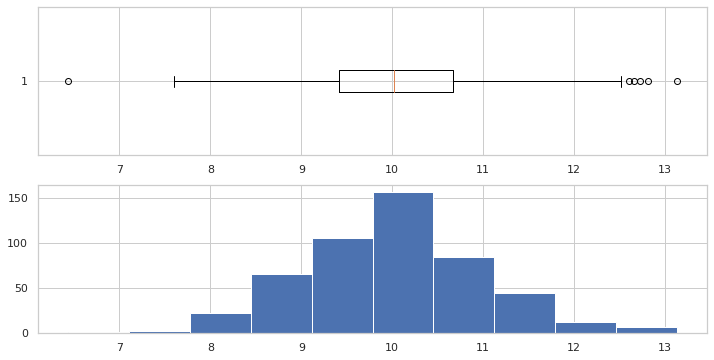

In [21]:
fig, ax = plt.subplots(2, 1)
ax[0].boxplot(sample_1, vert=False)
ax[1].hist(sample_1)
plt.show()

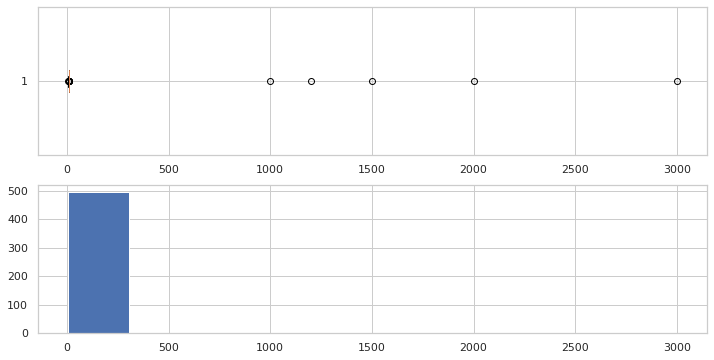

In [22]:
fig, ax = plt.subplots(2, 1)
ax[0].boxplot(sample_2, vert=False)
ax[1].hist(sample_2)
plt.show()

В группе treatment есть выбросы. Отбросим их и построим график еще раз

<AxesSubplot:xlabel='value', ylabel='Count'>

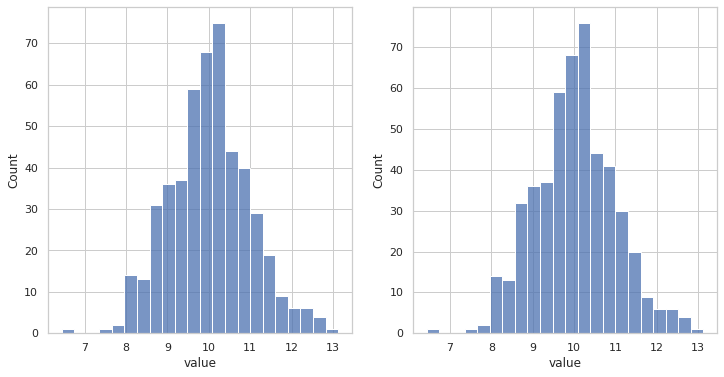

In [23]:
fig, ax = plt.subplots(1, 2)
sns.histplot(sample_2.loc[sample_2 < sample_2.quantile(.99)], ax=ax[0])
sns.histplot(sample_1, ax=ax[1])

In [ ]:
Видно, что без выбросов группы похожи

In [24]:
def get_bootstrap(
    sample_1, 
    sample_2, 
    boot_it = 1000, 
    statistic = np.mean,
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = sample_1.sample(
            len(sample_1), 
            replace = True
        ).values
        
        samples_2 = sample_2.sample(
            len(sample_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    #Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

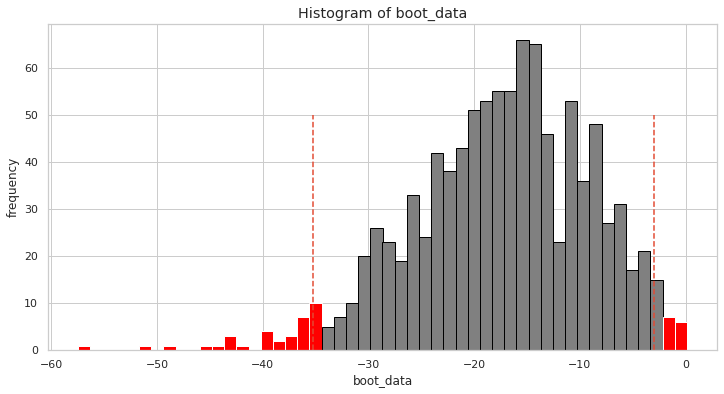

In [25]:
booted_data = get_bootstrap(sample_1, sample_2)

In [26]:
booted_data["p_value"] 

0.038376908273317675

Построим бустрап по медиане

In [35]:
def get_bootstrap_md(
    sample_1, 
    sample_2, 
    boot_it = 1000, 
    statistic = np.median,
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = sample_1.sample(
            len(sample_1), 
            replace = True
        ).values
        
        samples_2 = sample_2.sample(
            len(sample_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [36]:
booted_data_md = get_bootstrap_md(sample_1, sample_2)
booted_data_md["p_value"]

0.9388736011866162

Применим критерий Манна-Уитни

In [32]:
stats.mannwhitneyu(sample_1, sample_2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [34]:
stats.ttest_ind(sample_1,sample_2)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

Выводы:

1.Тестовая выборка имеет большие выбросы
2.Применяя бутстрап с оценкой среднего, нулевую гипотеза отклоняетя и можно сделать вывод, что тестовая и контрольная группы имеют различия. При этом бутстрап с использованием медианы не дает возможность отклонить нулевую гипотезу, так как p-value сильно больше 0.05
3.U-критерий Манна-Уитни не дал нам отклонить нулевую гипотезу: распределения отличаются не значительно и не нужно внедрять изменения